### Connecting to Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Package imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy

### Setting the seeds

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic= True
torch.backends.cudnn.benchmark= False
cudnn.benchmark = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# provide data directory
data_dir = '/content/drive/MyDrive/data'


# create image folders for our training and validation data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# get dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# get class_names from image_datasets
class_names = image_datasets['train'].classes

# use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}

In [ ]:
# change selected device to CUDA, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):

    # transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0))

    # use default values for mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # visualize the correct colors
    inp = std * inp + mean

    # view a clipped version of an image
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

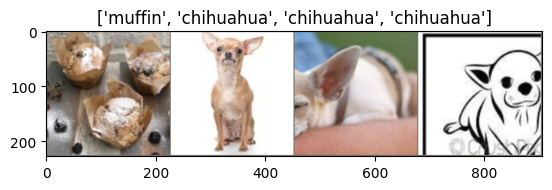

In [ ]:
# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

# plot the grid with a title that concatenates all the class labels
imshow(out, title=[class_names[x] for x in classes])

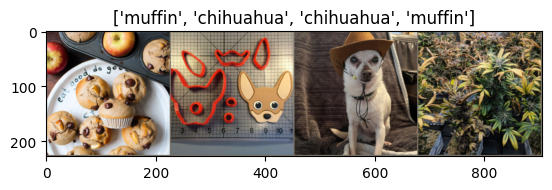

In [ ]:
# get a batch of testing data
inputs, classes = next(iter(dataloaders['val']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

# plot the grid with a title that concatenates all the class labels
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):

    since = time.time()

    # create a deep copy of the model provided
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # create a deep copy of the model

            if phase == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # for formatting
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:4f}')

    # load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(weights=True) ## loaded our model

num_ftrs = model_ft.fc.in_features

# move model to device
model_ft = model_ft.to(device)

# define loss function
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------
train Loss: 0.5371 Acc: 0.8883
val Loss: 0.4025 Acc: 0.8333

Epoch 1/7
----------
train Loss: 0.1763 Acc: 0.9422
val Loss: 0.2245 Acc: 0.8333

Epoch 2/7
----------
train Loss: 0.1325 Acc: 0.9529
val Loss: 0.6009 Acc: 0.8333

Epoch 3/7
----------
train Loss: 0.1144 Acc: 0.9630
val Loss: 0.6570 Acc: 0.8333

Epoch 4/7
----------
train Loss: 0.1166 Acc: 0.9612
val Loss: 0.7566 Acc: 0.8333

Epoch 5/7
----------
train Loss: 0.1211 Acc: 0.9657
val Loss: 0.4428 Acc: 0.8333

Epoch 6/7
----------
train Loss: 0.0943 Acc: 0.9688
val Loss: 0.2352 Acc: 0.8333

Epoch 7/7
----------
train Loss: 0.1089 Acc: 0.9691
val Loss: 0.0697 Acc: 1.0000

Training complete in 28m 14s
Best val Acc: 1.000000
